## 필수 라이브러리 import

In [41]:
import numpy as np                                      # 수치 연산
import pandas as pd                                     # DataFrame 조작
import seaborn as sns                                   # 시각화 (차트)
import matplotlib.pyplot as plt                         # 그래프 생성

import torch                                            # Tensor 연산
import torch.nn as nn                                   # 신경망 레이어
import torch.nn.functional as F                         # 손실/활성화 함수
import torch.optim as optim                             # 최적화 함수
from torch.utils.data import TensorDataset, DataLoader  # 미니배치 데이터 구성용
from tqdm.auto import tqdm                              # 진행바

from sklearn.model_selection import train_test_split    # 학습/(검증)/테스트 데이터 분리
from sklearn.preprocessing import StandardScaler        # 표준화 스케일러(평균0 표준편차 1)

In [42]:
# 재현성 설정 함수
def set_seed(seed = 42 ):
    np.random.seed(seed)                        # numpy 난수 고정
    torch.manual_seed(seed)                     # torch CPU 사용 시 난수 고정
    torch.cuda.manual_seed_all(seed)            # torch GPU 사용 시 난수 고정 (GPU 가용 시)
    torch.backends.cudnn.deterministic == True  # cuDNN 재현성 우선
    torch.backends.cudnn.benchmark = False      # cuDNN 최적화 탐색 비활성화 (재현성 우선)

set_seed(42)

In [43]:
# 데이터 불러오기

df = pd.read_csv("./data/fetch_california_housing.csv")
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [44]:
df = df.rename(columns= {'MedHouseVal': 'Target'})  # MedHouseVal -> Target 컬럼명 변경
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [45]:
# 데이터 분리 및 분할
X = df.drop(columns = ['Target']).values
y = df[["Target"]].values

# 학습/검증 데이터로 분리 
X_train, X_val, y_train, y_val= train_test_split(
    X, y,
    test_size= 0.2,
    random_state= 42
)


print((f"X_train: {X_train.shape}, X_val : {X_val.shape},y_train: {y_train.shape}, y_val : {y_val.shape}"))

X_train: (16512, 8), X_val : (4128, 8),y_train: (16512, 1), y_val : (4128, 1)


In [46]:
# 스케일링 적용 (X_train, X_val)
scaler =  StandardScaler()

X_train = scaler.fit_transform(X_train)     # train 데이터를 기준으로 표준화 변환
X_val = scaler.transform(X_val)             # val 데이터를 기준으로 변환

X_train

array([[-0.326196  ,  0.34849025, -0.17491646, ...,  0.05137609,
        -1.3728112 ,  1.27258656],
       [-0.03584338,  1.61811813, -0.40283542, ..., -0.11736222,
        -0.87669601,  0.70916212],
       [ 0.14470145, -1.95271028,  0.08821601, ..., -0.03227969,
        -0.46014647, -0.44760309],
       ...,
       [-0.49697313,  0.58654547, -0.60675918, ...,  0.02030568,
        -0.75500738,  0.59946887],
       [ 0.96545045, -1.07984112,  0.40217517, ...,  0.00707608,
         0.90651045, -1.18553953],
       [-0.68544764,  1.85617335, -0.85144571, ..., -0.08535429,
         0.99543676, -1.41489815]], shape=(16512, 8))

In [47]:
# 디바이스 설정 (GPU 사용 가능 시 CUDA, 아니면 CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 텐서 형태로 변환 후 .to(device)
X_train_t = torch.FloatTensor(X_train).to(device)
y_train_t = torch.FloatTensor(y_train).to(device)
X_val_t   = torch.FloatTensor(X_val).to(device)
y_val_t   = torch.FloatTensor(y_val).to(device)


print(f"X_train_t: {X_train_t.size()},y_train_t: {y_train_t.size()},X_train_t: {X_train_t.size()},y_val_t: {y_val_t.size()}")

X_train_t: torch.Size([16512, 8]),y_train_t: torch.Size([16512, 1]),X_train_t: torch.Size([16512, 8]),y_val_t: torch.Size([4128, 1])


Tensor 로 변환

1. torch.FloatTensor
2. torch.from_numpy(..).float()

In [48]:
# 학습 미니배치 설정
batch_size = 256        # 미니배치 크기 (한 번에 학습할 샘플 수)

# 학습용 DataLoader : 미니배치 + 셔플
train_loader = DataLoader(
    TensorDataset(X_train_t, y_train_t),    # 학습 데이터의 (입력,,타겟) 텐서를 하나의 데이터셋으로 묶어 제공
    batch_size = batch_size,                # 배치 단위로 데이터를 잘라서 제공 
    shuffle = True                          # 매 epoch 마다 데이터 순서를 섞어 학습 (일반화 성능)
)

# 검증용 DataLoader : 미니배치 + 셔플
val_loader = DataLoader(
    TensorDataset(X_val_t, y_val_t),
    batch_size = batch_size,
    shuffle = False                         # 검증데이터는 순서를 고정 (평가 결과가 일관성이 있어야 함)
)   

In [49]:
# 가중치 초기화 함수 : Linear에 kaiming 초기화 (LeakyReLU 계열에 적합한 초기화 기법)
def init_weights(m):
    if isinstance(m, nn.Linear):            # Linear 레이어만 초기화 진행 
        nn.init.kaiming_normal_(m.weight, a = 0.01, nonlinearity = 'leaky_relu')    # He 초기화(LeakyReLU용)
        if m.bias is not None:
            nn.init.zeros_(m.bias)          # bias 는 0으로 초기화 

In [50]:
# Residual Block : (Linear -> BN -> Act -> Dropout -> Linear -> BN) + shortcut 구조
class ResidualBlock(nn.Module):
    def __init__(self, in_dim, out_dim, dropout_p = 0.1, negativate_slope = 0.01):
        super().__init__()                                              # nn.Module 초기화
        self.fc1 = nn.Linear(in_dim, out_dim)                           # 1번째 선형 변환
        self.bn1 = nn.BatchNorm1d(out_dim)                              # 배치 정규화 (학습 안정성)
        self.act = nn.LeakyReLU(negative_slope = negativate_slope)      # LeakyReLU 활성화 함수
        self.drop = nn.Dropout(dropout_p)                               # Dropout (과적합 완화)

        self.fc2 = nn.Linear(out_dim, out_dim)                          # 2번째 선형 반환
        self.bn2 = nn.BatchNorm1d(out_dim)                              # 배치 정규화 (학습 안정성)

        self.shortcut = nn.Identity()                                   # 입력 = 출력이면 그대로 연결
        if in_dim != out_dim:                                           # 다르면 
            self.shortcut = nn.Linear(in_dim, out_dim)                  # 선형으로 맞춰서 더해준다.

    def forward(self, x):
        h = self.fc1(x)             # 선형 변환 1
        h = self.bn1(h)             # 배치 정규화 1
        h = self.act(h)             # 활성화
        h = self.drop(h)            # 드롭 아웃

        h = self.fc2(h)             # 선형 변환 2
        h = self.bn2(h)             # 배치 정규화 2

        x = self.shortcut(x)        # residual shortcut 준비
        out = self.act(h + x)       # residual 합 + 활성화
        
        return out

In [51]:
# MLP 모델 클래스 : ResidualBlock을 여러 개 쌓고 마지막에 회귀 출력층(head)를 붙인 구조
class ResidualMLP(nn.Module):
    def __init__(self, imput_dim, hidden_dims = (128, 128, 64), dropout_p = 0.1):
        super().__init__()                                              # nn.Module 초기화 (파라미터 등록 준비)
        dims = (imput_dim,) + tuple(hidden_dims)                        # 레이어 차원 목록 생성 (입력 -> 은닉1 -> 은닉2 -> 은닉3)
        self.blocks = nn.ModuleList([                                   # 블록들을 리스트로 보관 (학습 파라미터 등록됨)
            ResidualBlock(dims[i], dims[i+1], dropout_p = dropout_p)    # dim[i] -> dim[i + 1] 로 가는 ResidualBlock 생성
            for i in range(len(dims) - 1)                               # 은닉층 개수만큼 반복해서 블록 구성
        ])                                                              # -> 여러 ResialBlock 을 순차적으로 쌓은 블록 구성

        self.head = nn.Linear(dims[-1], 1)                              # 마지막 은닉 차원 -> 출력 1개(회귀값) 으로 변환하는 출력층 

    def forward(self, x):   
        for blk in self.blocks:
            x = blk(x)                                                  # 입력을 각 REsidualBlock 에 순서대로 통과
        return self.head(x)                                             # 최종 출력층을 거쳐 예측값(회귀) 변환

ResidualBlock 사용하는 방식은 지름길(shortcut) 방식이다.   
일반 MLP(깊게 쌓기): $x -> F(x)$   
Residual(지름길 추가) : $x -> x + F(x)$   
=> 지름길은 그냥 원래 입력 x 를 그대로 더해주는 경로를 추가한다.   

사용 이유 : 최적화, 과적합 방지, 안정화, 층을 깊게 쌓을 경우


In [52]:
model = ResidualMLP(imput_dim = X_train.shape[1]).to(device)    # 입력 특성 개수를 입력 차원으로 사용하여 모델 객체 생성 

model.apply(init_weights)       # 모델 내 Linear 레이어에 가중치 초기화 함수 적용



ResidualMLP(
  (blocks): ModuleList(
    (0): ResidualBlock(
      (fc1): Linear(in_features=8, out_features=128, bias=True)
      (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): LeakyReLU(negative_slope=0.01)
      (drop): Dropout(p=0.1, inplace=False)
      (fc2): Linear(in_features=128, out_features=128, bias=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Linear(in_features=8, out_features=128, bias=True)
    )
    (1): ResidualBlock(
      (fc1): Linear(in_features=128, out_features=128, bias=True)
      (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): LeakyReLU(negative_slope=0.01)
      (drop): Dropout(p=0.1, inplace=False)
      (fc2): Linear(in_features=128, out_features=128, bias=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Identity

In [53]:
# 손실함수 설정 
criterion = nn.SmoothL1Loss(beta = 1.0) # Huder 손실 (=SmoothL1Loss)

SmoothL1Loss 는 MSE보다 이상치 덜 민감. 안정적인 학습을 위해 사용

In [54]:
# 최적화 함수 설정 
learning_rate = 1e-3            # 학습률
weight_decay = 1e-2             # 가중치 감쇠(L2 규제) : 큰 가중치가 되는 것을 억제 (과적합 완화)

optimizer = optim.AdamW(        
    model.parameters(),         # 최적화할 대상 (모델의 모든 학습 파라미터)
    lr = learning_rate,
    weight_decay =weight_decay  # 가중치 감쇠 (정규화 효과)
)

In [55]:
# 스케줄러 설정 : val_loss 가 더 이상 좋아지지 않으면 학습률을 줄여 (미세 조정) 수렴을 도움
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,      # 학습률을 조정할 대상 옵티마이저
    mode = "min",   # val_loss 를 작게 만드는 방향으로 판단
    factor= 0.5,    # 개선이 없으면 lr를 0.5배로 감소
    patience= 5     # 5 epochs 동안 개선 없으면 실행
)

In [56]:
# Early Stopping 설정 
patience = 20                       # 개선이 없을 때 기다릴 eopch 수
min_delta = 1e-6                    # 개선으로 인정할 최소 감소 폭
best_val_loss = float("inf")        # 최고 성능(val_loss 최저일때의 loss)
best_state = None                   # best 모델의 파라미터 저장
patience_cnt = 0                    # early stopping 카운터

In [57]:
# 학습 설정
n_epochs = 4000
print_interval = 200

In [58]:
# 학습 및 검증 루프
for epoch in tqdm(range(1, n_epochs + 1), desc="Training"):
    model.train()                       # 학습 모드 전환
    train_loss_sum = 0.0                # train 손실 누적
    train_n = 0                         # train 샘플 수 누적

    for xb, yb in train_loader:
        pred = model(xb)                # 순전파
        loss = criterion(pred, yb)      # 손실계산 (Huber)

        optimizer.zero_grad()           # 기울기 초기화
        loss.backward()                 # 역전파 : 기울기 계산
        nn.utils.clip_grad_norm_(model.parameters(), 5.0)   # 기울기 폭발 방지용 클리핑
        optimizer.step()                # 파라미터 업데이트

        train_loss_sum += loss.item() * xb.size(0)  # 배치 손실을 샘플 수로 가중 누적
        train_n += xb.size(0)                       # 샘플 수 누적

    train_loss = train_loss_sum / train_n   # epoch 평균 학습 손실

    
    model.eval()                            # 평가모드
    val_loss_sum = 0.0                      # val 손실 누적용
    val_n = 0                               # val 샘플 수 누적용

    with torch.no_grad():                   # 가중치 업데이트 하지 않음
        for xb, yb in val_loader:
            pred = model(xb)                # 순전파 : 검증 예측
            loss = criterion(pred, yb)      # 검증 손실 계산
            val_loss_sum += loss.item() * xb.size(0)    # 샘플 수로 가중 누적
            val_n += xb.size(0)             # 샘플 수 누적

    val_loss = val_loss_sum / val_n         # epoch 평균 검증 손실

    # Scheduler
    prev_lr = optimizer.param_groups[0]["lr"]   # step 전 lr 값
    scheduler.step(val_loss)                    # val_loss 기준으로 스케줄러 step
    cur_lr = optimizer.param_groups[0]["lr"]    # step 후 lr 값
    if cur_lr != prev_lr:
        print(f"LR reduced: {prev_lr:.2e} -> {cur_lr:.2e}") # lr 값 변동 시 출력

    # Logging
    if epoch % print_interval == 0:
        print(f"Epoch {epoch}: train_loss={train_loss:.4e}, val_loss={val_loss:.4e}")   #손실값 출력

    # Early Stopping
    if best_val_loss - val_loss > min_delta:    # 최고 loss값 변동이 있으면
        best_val_loss = val_loss                # best_val_loss 값 업데이트
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}   # best 파라미터 저장
        patience_cnt = 0                        # 카운터 초기화
    else:
        patience_cnt += 1
        if patience_cnt >= patience:            
            print(f"Early Stopping at epoch {epoch}, best_val_loss={best_val_loss:.4f}")
            break

Training:   1%|          | 45/4000 [00:15<22:13,  2.97it/s] 

LR reduced: 1.00e-03 -> 5.00e-04


Training:   1%|▏         | 52/4000 [00:17<21:33,  3.05it/s]

LR reduced: 5.00e-04 -> 2.50e-04


Training:   2%|▏         | 68/4000 [00:22<17:51,  3.67it/s]

LR reduced: 2.50e-04 -> 1.25e-04


Training:   2%|▏         | 74/4000 [00:24<19:17,  3.39it/s]

LR reduced: 1.25e-04 -> 6.25e-05


Training:   2%|▏         | 88/4000 [00:28<18:07,  3.60it/s]

LR reduced: 6.25e-05 -> 3.13e-05


Training:   2%|▏         | 94/4000 [00:30<23:00,  2.83it/s]

LR reduced: 3.13e-05 -> 1.56e-05


Training:   2%|▎         | 100/4000 [00:32<19:02,  3.41it/s]

LR reduced: 1.56e-05 -> 7.81e-06


Training:   3%|▎         | 101/4000 [00:33<21:23,  3.04it/s]

Early Stopping at epoch 102, best_val_loss=0.1143


In [59]:
# best 모델 가중치를 가지고 best 모델 복원
if best_state is not None:
    model.load_state_dict(best_state)       # best 파라미터 적용
    

In [60]:
# 최종 예측
model.eval()                                                # 평가 모드 
with torch.no_grad():
    y_val_pred = model(X_val_t).detach().cpu()              # 검증 예측값
    y_val_true = y_val_t.detach().cpu()                     # 검증 정답값

df_pred = pd.DataFrame(
    torch.cat([y_val_true, y_val_pred],dim= 1 ).numpy(),    # 실제 값과 예측 값 데이터 이어붙임
    columns= ["y", "y_hat"]

)
df_pred

,y,y_hat
0,0.47700,0.512048
1,0.45800,0.797624
2,5.00001,5.114174
3,2.18600,2.523119
4,2.78000,2.492212
...,...,...
4123,2.63300,2.339833
4124,2.66800,2.123677
4125,5.00001,4.714633
4126,0.72300,0.718683


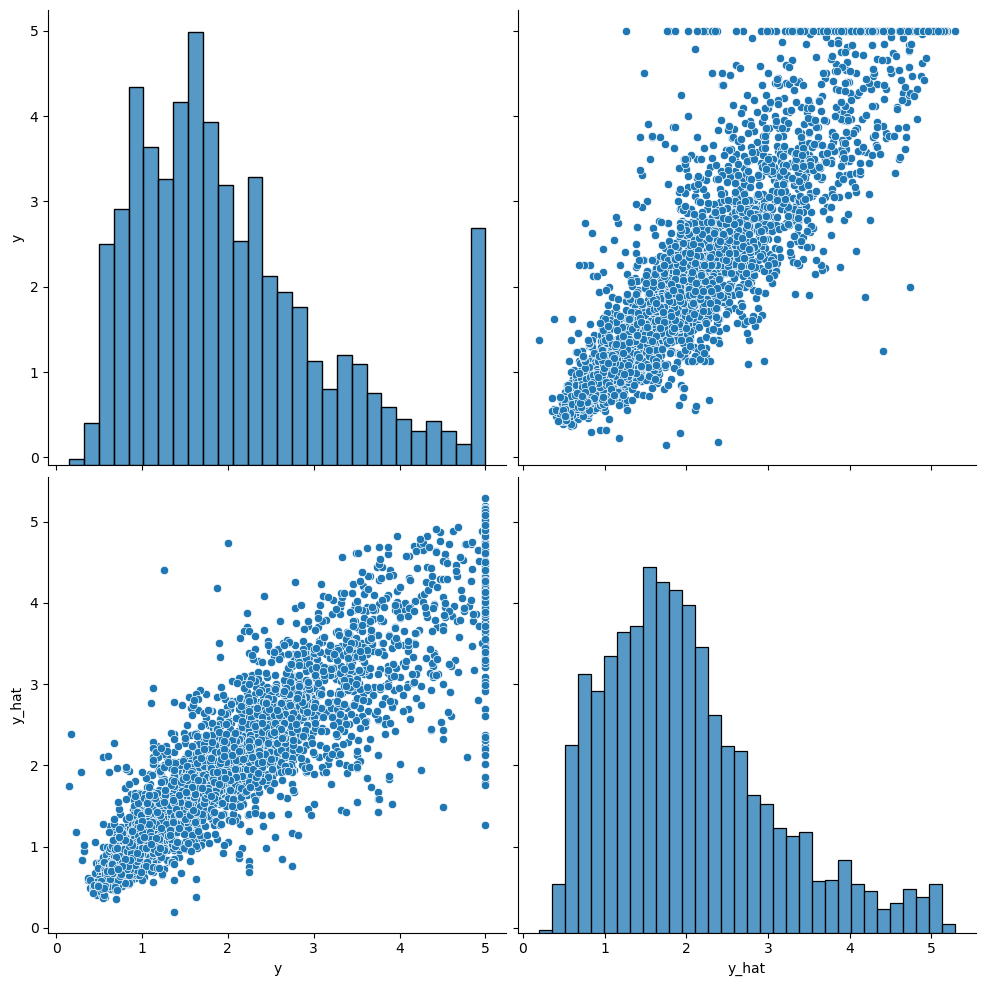

In [61]:
sns.pairplot(df_pred, height= 5)
plt.show()